In [38]:
# Import packages
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from set_paths import data_path
from scipy import stats
from dtw import *

In [39]:
### Load data ###

## Load data input to UMAP ##
struct_data = sio.loadmat(os.path.join(data_path, "umap_input_data.mat"))['mat']

# Initialize an empty list to store the field data
field_data_list = []
# Iterate over each field in the struct
for field_name in struct_data.dtype.names:
    # Extract the 2-dimensional array from each field
    field_data = struct_data[field_name][0]
    # Flatten the nested arrays
    field_data_flat = np.concatenate(field_data).ravel()
    # Append the flattened field data to the list
    field_data_list.append(field_data_flat)
# Create the DataFrame from the list of flattened field data
input_data = pd.DataFrame(field_data_list).transpose()
# Column names
colnames = ['age','global_efficiency','path_length', 'small_worldness','strength',
            'modularity', 'core/periphery', 'score', 'local_efficiency', 
            'clustering', 'betweenness', 'subgraph_centrality']
input_data.columns = colnames
ages = input_data['age']
# Group by age
grouped_input_data = input_data.groupby('age').mean().reset_index()


## Load PCA sscores ##
mat_file = sio.loadmat(os.path.join(data_path, "pca_scores.mat"))
pca_scores = np.array(mat_file['score'])
pca_scores = pd.DataFrame(pca_scores, columns=['PC1', 'PC2', 'PC3'])

In [40]:
### Define variables ###

# Metrics
measures = ['Global Efficiency', 'Path Length', 'Small-Worldness','Strength',
                  'Modularity', 'Core/Periphery', 'S-Core', 'Local Efficiency', 
                  'Clustering Coefficient', 'Betweenness Centrality', 'Subgraph Centrality']
# Epochs
epoch_ranges = [
    (0,8),
    (8,32),
    (32,62),
    (62,85),
    (85,90)]

# Colors for epochs
line_colors = ['#FF5AAF','#008DF9','#FFC33B','#009F81','#A40122']

In [41]:
### Turn PC scores in series ###

# Get averages
pca_scores['age'] = input_data['age']
score_means = pca_scores.groupby('age').mean()

# Initialize values
pc1_timeseries = np.zeros([len(epoch_ranges)], dtype="object")
pc2_timeseries = np.zeros([len(epoch_ranges)], dtype="object")
pc3_timeseries = np.zeros([len(epoch_ranges)], dtype="object")
# Loop through each epoch and save series 
for epoch_index, (start, end) in enumerate(epoch_ranges):

    # Pull data
    epoch_data = score_means[(score_means.index.get_level_values('age') >= start) 
                             & (score_means.index.get_level_values('age') <= end)]
    # Save seperate time series
    pc1_timeseries[epoch_index] = epoch_data['PC1']
    pc2_timeseries[epoch_index] = epoch_data['PC2']
    pc3_timeseries[epoch_index] = epoch_data['PC3']

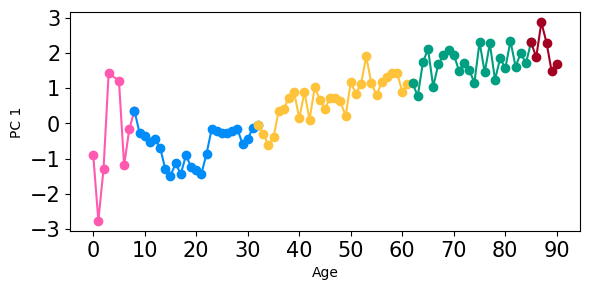

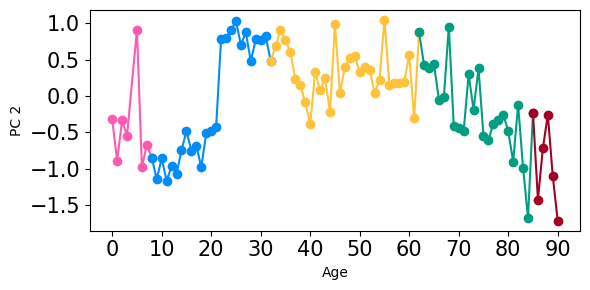

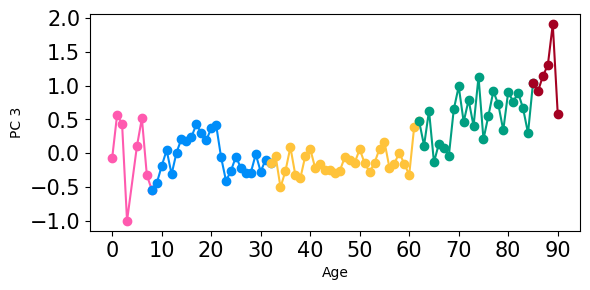

In [42]:
### Extended Data Figure 4c ###

# PC 1
plt.figure(figsize=(6, 3))
# Loop through each series and plot
for idx, series in enumerate(pc1_timeseries):
    age = series.index        # Get age from the index
    pc_value = series.values  # Get PC values from the series
    plt.plot(age, pc_value, 'o-', color=line_colors[idx], label=f'Series {idx+1}')
plt.yticks(color='black',family='Arial',size=15)
plt.xticks(range(0, 91, 10), color='black', family='Arial', size=15)
plt.xlabel("Age")
plt.ylabel("PC 1")
plt.grid(False)
plt.tight_layout()
# Show the plot
plt.show()

# PC 2
plt.figure(figsize=(6, 3))
# Loop through each series and plot
for idx, series in enumerate(pc2_timeseries):
    age = series.index  
    pc_value = series.values  
    plt.plot(age, pc_value, 'o-', color=line_colors[idx], label=f'Series {idx+1}')
plt.yticks(color='black',family='Arial',size=15)
plt.xticks(range(0, 91, 10), color='black', family='Arial', size=15)
plt.xlabel("Age")
plt.ylabel("PC 2")
plt.grid(False)
plt.tight_layout()
# Show the plot
plt.show()

# PC 3
plt.figure(figsize=(6, 3))
# Loop through each series and plot
for idx, series in enumerate(pc3_timeseries):
    age = series.index  
    pc_value = series.values  
    plt.plot(age, pc_value, 'o-', color=line_colors[idx], label=f'Series {idx+1}')
plt.yticks(color='black',family='Arial',size=15)
plt.xticks(range(0, 91, 10), color='black', family='Arial', size=15)
plt.xlabel("Age")
plt.ylabel("PC 3")
plt.grid(False)
plt.tight_layout()
# Show the plot
plt.show()

In [43]:
### Run dynamic time warping ###

# Number of epochs
num_series = len(pc1_timeseries)
# Initialize
pc1_distances = np.zeros((num_series, num_series))
pc2_distances = np.zeros((num_series, num_series))
pc3_distances = np.zeros((num_series, num_series))

# Loop through epochs
for i in range(num_series):
    # Loop through epochs to warp
    for j in range(i+1,num_series):
        # PC1
        series1 = pc1_timeseries[i].reset_index(drop=True)
        series2 = pc1_timeseries[j].reset_index(drop=True)
        # Calculate DTW distance
        alignment = dtw(series1, series2, keep_internals=True)
        pc1_distances[i][j] = alignment.distance
        pc1_distances[j][i] = alignment.distance
        # PC2
        series1 = pc2_timeseries[i].reset_index(drop=True)
        series2 = pc2_timeseries[j].reset_index(drop=True)
        # Calculate DTW distance
        alignment = dtw(series1, series2, keep_internals=True)
        pc2_distances[i][j] = alignment.distance
        pc2_distances[j][i] = alignment.distance

        # PC3
        series1 = pc3_timeseries[i].reset_index(drop=True)
        series2 = pc3_timeseries[j].reset_index(drop=True)
        # Calculate DTW distance
        alignment = dtw(series1, series2, keep_internals=True)
        pc3_distances[i][j] = alignment.distance
        pc3_distances[j][i] = alignment.distance

In [44]:
### Standardize distance scores ###

# Create mask to only pull bottom triangle
mask = np.tril(np.ones((num_series, num_series), dtype=bool), k=-1)

## PC 1 ##
# Initialize
pc1_standard_matrix = np.zeros((num_series,num_series), dtype=float)
# Calculate Z-score
standard_scores = stats.zscore(pc1_distances[mask])
pc1_standard_matrix[np.triu_indices(num_series, k=1)] = standard_scores
pc1_standard_matrix += pc1_standard_matrix.T
pc1_standard_matrix

## PC 2 ##
pc2_standard_matrix = np.zeros((num_series,num_series), dtype=float)
# Calculate Z-score
standard_scores = stats.zscore(pc2_distances[mask])
pc2_standard_matrix[np.triu_indices(num_series, k=1)] = standard_scores
pc2_standard_matrix += pc2_standard_matrix.T
pc2_standard_matrix

## PC 3 ##
pc3_standard_matrix = np.zeros((num_series,num_series), dtype=float)
# Calculate Z-score
standard_scores = stats.zscore(pc3_distances[mask])
pc3_standard_matrix[np.triu_indices(num_series, k=1)] = standard_scores
pc3_standard_matrix += pc3_standard_matrix.T
pc3_standard_matrix

# Save standardized distances
standard_distance_data = [pc1_standard_matrix,pc2_standard_matrix,pc3_standard_matrix] 
# Pull out consecutive warps
first_second =  np.zeros(3, dtype=float)
second_third =  np.zeros(3, dtype=float)
third_fourth =  np.zeros(3, dtype=float)
fourth_fifth =  np.zeros(3, dtype=float)
for i, (score, title) in enumerate(zip(standard_distance_data, measures)):
    first_second[i] = score[0,1]
    second_third[i] = score[1,2]
    third_fourth[i] = score[2,3]
    fourth_fifth[i] = score[3,4]
# Save consecutive warps
e_values = np.array([first_second, second_third, third_fourth, fourth_fifth])

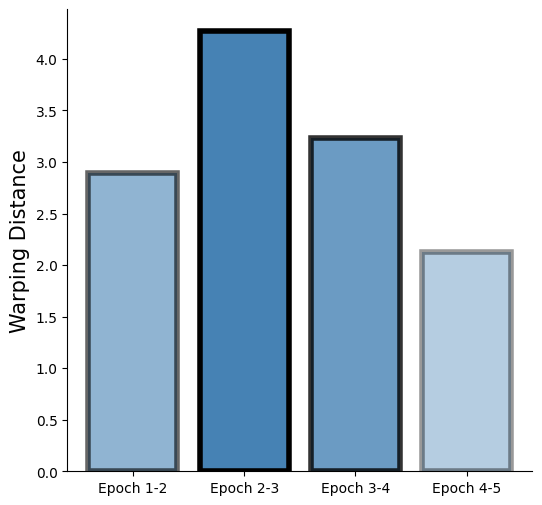

In [45]:
### Figure 5b ###

# Sum distances across all PCs
sum_distance = pd.DataFrame(np.sum(np.abs(e_values), axis=1), columns=['sum_distance'])
sum_distance = sum_distance['sum_distance'].tolist()

# Plot
fig, ax = plt.subplots(figsize=(6,6))
x_values = np.arange(len(pc1))

# Define alphas for each epoch range
alphas = [0.6, 1.0, 0.8, 0.4]
plot_labels = ['Epoch 1-2','Epoch 2-3', 'Epoch 3-4','Epoch 4-5']

# Plot bars with different alphas and black outline
bars = ax.bar(x_values, sum_distance, color='#4682B4', edgecolor='black',linewidth=4)

# Apply different alphas to the bars based on epoch ranges
for i in range(len(pc1)):
    bars[i].set_alpha(alphas[i])

# Remove the box around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title with increased font size
ax.set_ylabel('Warping Distance', color='black', family='Arial', fontsize=15)
ax.set_xticks(np.arange(len(pc1)))
ax.set_xticklabels(plot_labels, family='Arial', fontsize=10)
ax.tick_params(axis='y', labelsize=10)

# Show the plot
plt.show()